## Twitter sentiment Analysis


### Project Overview

In a dynamic digital landscape, understanding public sentiment towards technology giants like Apple and Google is paramount. This project aims to harness the power of Natural Language Processing (NLP) to conduct a comprehensive sentiment analysis of tweets related to their products. By leveraging a dataset containing over 9,000 manually annotated tweets, we seek to create a robust model that discerns sentiments as positive, negative, or neutral. The multifaceted nature of this analysis offers valuable insights for businesses, marketing strategists, and researchers invested in the consumer electronics domain.

### Business Understanding

In the era of social media dominance, the reputation and perception of tech companies can be heavily influenced by user-generated content. Understanding the sentiment expressed on platforms like Twitter provides a unique opportunity to gauge public perception, inform strategic decisions, and enhance customer engagement strategies. By delving into the sentiment surrounding Apple and Google products, businesses can gain actionable insights, refine their marketing approaches, and maintain a pulse on the evolving consumer landscape.

### Objectives:

1. Initiate the project with a focused binary classifier to distinguish positive and negative sentiments. Gradually extend the model's capabilities to handle neutral sentiments, ensuring a robust multiclass classification system(Proof of Concept).

2. Develop a sophisticated NLP model capable of accurately classifying tweet sentiments as positive, negative, or neutral, providing nuanced insights into the public's opinions(Sentiment Analysis).

3. Continuously refine the model's architecture and parameters, drawing inspiration from advanced NLP techniques documented in the Mod 4 Appendix. This iterative approach ensures optimal performance and adaptability to the evolving landscape of social media language(Model Iteration)


Importing the necessary libraries.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re

from nltk.corpus import words
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC



%matplotlib inline

Functions used in the project:

In [3]:
def load_csv_to_dataframe(file_path):
    """
    Load a CSV file into a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the CSV file.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    df = pd.read_csv(file_path, encoding='latin-1')
    return df

def dataframe_preview(dataframe):
    #To get the shape of the dataframe
    print("The shape of the dataframe:")
    print(dataframe.shape)
    print('\n')
    #Describe the dataframe
    print("Describing the dataframe:")
    print(dataframe.describe())
    print('\n')
    #checking the columns in the dataset
    print("Columns in the dataset:")
    print(dataframe.columns)
    print('\n')
    #To get the info of the dataframe
    print("The data in the dataframe:")
    print(dataframe.info())
    print('\n')

def clean_tweet_text(text):
    try:
        cleaned_text = re.sub(r'@\w+', '', str(text))
        cleaned_text = re.sub(r'http\S+|www\S+|[^a-zA-Z\s]', '', cleaned_text)
        cleaned_text = cleaned_text.encode('ascii', 'ignore').decode()
        return cleaned_text
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return text

def extract_hashtag_words(text):
    try:
        hashtags = re.findall(r'#(\w+)', text)
        h = ''
        for hashtag in hashtags:
            h += str(hashtag) + ','
        return h.lower()
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return text



## Data understanding

### Loading data
In this section, we will upload data and conduct surface analysis whereby we will check  the shape,check for null values

In [4]:
# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'tweet_product_company.csv'

# Load the CSV file into a pandas DataFrame
df = load_csv_to_dataframe(file_path)

# Display the DataFrame
print(df)

                                             tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

     emotion_in_tweet_is_directed_at  \
0                             iPhone   
1                 iPad or iPhone App   
2                               iPad   
3                 iPad or iPhone App   
4                             Google   
...                              ...   
9088       

In [5]:
#Call function to preview the data
dataframe_preview(df)

The shape of the dataframe:
(9093, 3)


Describing the dataframe:
                                               tweet_text  \
count                                                9092   
unique                                               9065   
top     RT @mention Marissa Mayer: Google Will Connect...   
freq                                                    5   

       emotion_in_tweet_is_directed_at  \
count                             3291   
unique                               9   
top                               iPad   
freq                               946   

       is_there_an_emotion_directed_at_a_brand_or_product  
count                                                9093  
unique                                                  4  
top                    No emotion toward brand or product  
freq                                                 5389  


Columns in the dataset:
Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directe

## Data cleaning

We will now proceed to cleaning the data.This involves removing duplicates and droping null values which were observed above. We will also try to extract all usefull information from the tweet removing unneccessary characters like usernames, links and special characters.

In [6]:
#Dropping duplicate entries in the tweet_text column
df.drop_duplicates(subset='tweet_text', keep='first', inplace=True)


In [7]:
# Check the dataframe
dataframe_preview(df)

The shape of the dataframe:
(9066, 3)


Describing the dataframe:
                                               tweet_text  \
count                                                9065   
unique                                               9065   
top     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
freq                                                    1   

       emotion_in_tweet_is_directed_at  \
count                             3280   
unique                               9   
top                               iPad   
freq                               943   

       is_there_an_emotion_directed_at_a_brand_or_product  
count                                                9066  
unique                                                  4  
top                    No emotion toward brand or product  
freq                                                 5373  


Columns in the dataset:
Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directe

In [8]:
#checking for total null values for each column in the dataset
missing_values = df.isnull().sum()

print(missing_values)

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5786
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


In [9]:
#Drop the null values
df = df.dropna(subset=['tweet_text'])

In [10]:
#Check if all missing values are dropped.
missing_values = df.isnull().sum()

print(missing_values)

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5785
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


This code uses regular expressions to replace user mentions, remove links, and non-alphanumeric characters. If you want to retain hashtags, you can uncomment the 'hashtags' line. Adjustments can be made based on specific cleaning requirements.

In [ ]:

def clean_tweet_text(text):
    try:
        cleaned_text = re.sub(r'@\w+', '', str(text))
        cleaned_text = re.sub(r'http\S+|www\S+|[^a-zA-Z\s]', '', cleaned_text)
        cleaned_text = cleaned_text.encode('ascii', 'ignore').decode()
        return cleaned_text
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return text

In [1]:
#  df is the DataFrame containing the dataset
df['clean_text'] = df['tweet_text'].apply(clean_tweet_text)
df['hashtags'] = df['tweet_text'].apply(extract_hashtag_words)

df['clean_text'][0]


NameError: name 'df' is not defined

In [28]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [42]:
# Convert text to lowercase
df['clean_text'] = df['tweet_text'].apply(lambda x: clean_tweet_text(x).lower())

# Tokenization and stopwords removal
stop_words = set(stopwords.words('english'))
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Remove one-word sentences
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))


In [43]:
df.clean_text[0]

'iphone hr tweeting riseaustin dead need upgrade plugin station sxsw'

In [34]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_text,hashtags,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,iphone hr tweeting riseaustin dead need upgrad...,"rise_austin,sxsw,",Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,2,know awesome ipadiphone app youll likely appre...,"sxsw,",Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,2,wait ipad also sale sxsw,"ipad,sxsw,",Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,hope year festival isnt crashy year iphone app...,"sxsw,",Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,2,great stuff fri sxsw marissa mayer google tim ...,"sxsw,",Google


In [39]:

print("\nDistribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:")
print(emotion_directed_at_distribution)


Distribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:
No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


In [37]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product', 'clean_text',
       'hashtags', 'brand', 'binary_sentiment'],
      dtype='object')

In [ ]:
# Convert classes to numeric labels
df['binary_emotion'] = df['binary_emotion'].map({'Neutral': 0, 'Positive': 1})


In [36]:
# Create a binary target variable
df['binary_sentiment'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(
    lambda x: 'Negative' if x in ["No emotion toward brand or product", "I can't tell"] else 'Positive'
)

# Verify the distribution of the new binary target
binary_sentiment_distribution = df['binary_sentiment'].value_counts()
print("Distribution of 'binary_sentiment' values:")
print(binary_sentiment_distribution)


Distribution of 'binary_sentiment' values:
Positive    9065
Name: binary_sentiment, dtype: int64


### EDA

In [13]:
# Explore 'tweet_text' column
tweet_text_distribution = df['tweet_text'].value_counts()

# Explore 'emotion_in_tweet_is_directed_at' column
emotion_distribution = df['emotion_in_tweet_is_directed_at'].value_counts()

# Explore 'is_there_an_emotion_directed_at_a_brand_or_product' column
emotion_directed_at_distribution = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Display the distributions
print("Distribution of 'tweet_text' values:")
print(tweet_text_distribution)

print("\nDistribution of 'emotion_in_tweet_is_directed_at' values:")
print(emotion_distribution)

print("\nDistribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:")
print(emotion_directed_at_distribution)

Distribution of 'tweet_text' values:
.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.         1
RT @mention I think #Google lost their way by caring too much about their business (instead of their users) Tim O'Reilly #sxsw #pnid    1
RT @mention I just fell asleep for 2 hours with my eyes open, staring into the #SXSW stream on my iPad 2. {link}                        1
RT @mention I just found BBQ sauce on my iPad - tech and Texas really do come together here!  #SXSW                                     1
RT @mention I know it's #SXSW because my iPhone has started lying to me about its signal strength.                                      1
                                                                                                                                       ..
Apple Offers Up Free iTunes Sampler Ahead of #SXSW to feature new artists {link} via @mention #music                                   

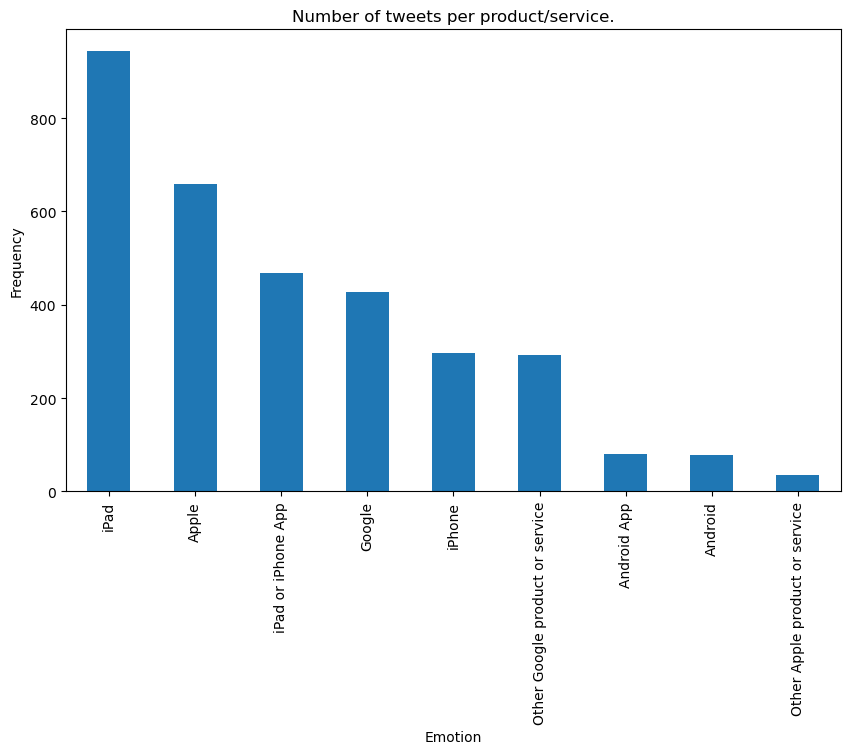

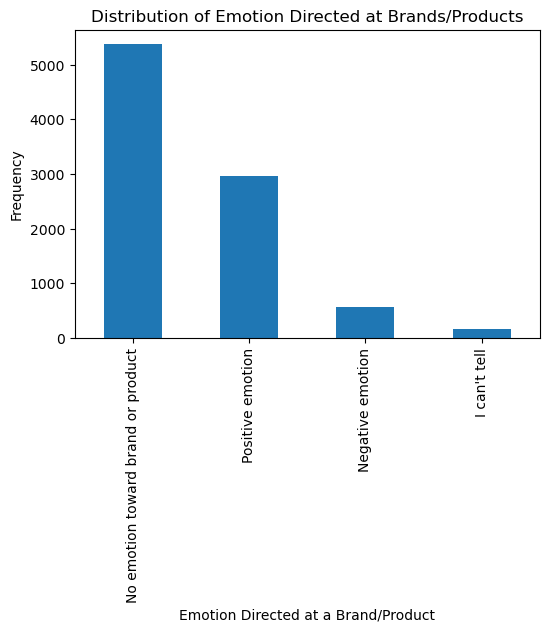

In [14]:
import matplotlib.pyplot as plt

# Bar chart for 'emotion_in_tweet_is_directed_at'
plt.figure(figsize=(10, 6))
emotion_distribution.plot(kind='bar')
plt.title('Number of tweets per product/service.')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

# Bar chart for 'is_there_an_emotion_directed_at_a_brand_or_product'
plt.figure(figsize=(6, 4))
emotion_directed_at_distribution.plot(kind='bar')
plt.title('Distribution of Emotion Directed at Brands/Products')
plt.xlabel('Emotion Directed at a Brand/Product')
plt.ylabel('Frequency')
plt.show()


In [15]:

print("\nDistribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:")
print(emotion_directed_at_distribution)


Distribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:
No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


In [16]:
# Assuming df is your DataFrame
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].replace({
    "I can't tell": 'Neutral emotion',
    'No emotion toward brand or product': 'Neutral emotion'
})

# Verify the changes
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())

Neutral emotion     5528
Positive emotion    2968
Negative emotion     569
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_16888\643437860.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emotion_in_tweet_is_directed_at', data=df, palette="viridis")


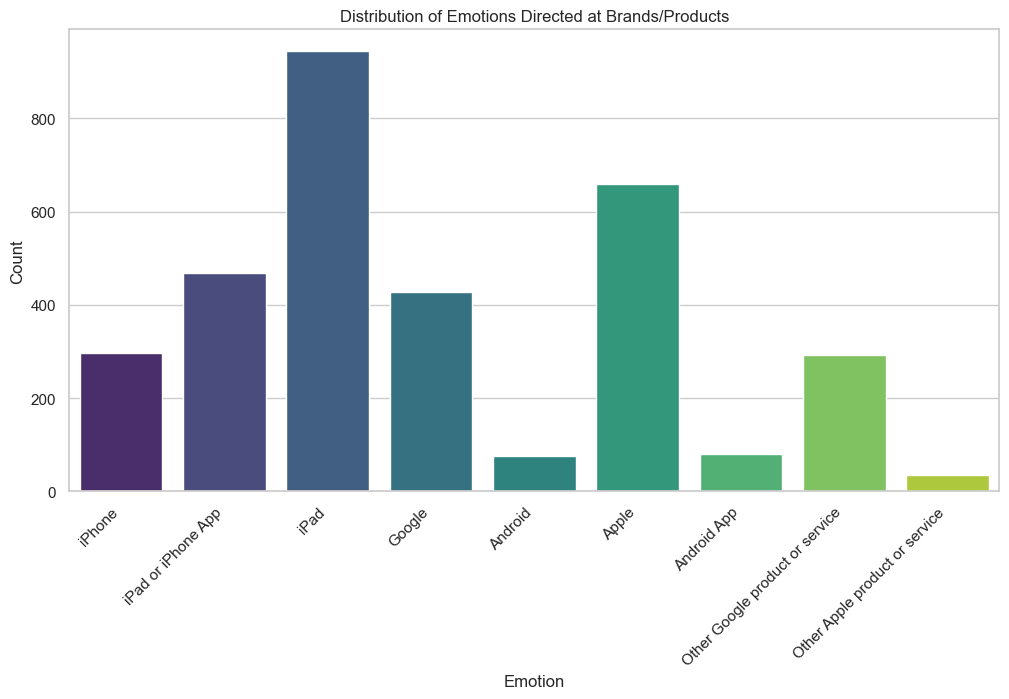

In [17]:
# Explore 'emotion_in_tweet_is_directed_at' column
emotion_distribution = df['emotion_in_tweet_is_directed_at'].value_counts()

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a colorful count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion_in_tweet_is_directed_at', data=df, palette="viridis")

# Add labels and title
plt.title('Distribution of Emotions Directed at Brands/Products')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


In [18]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [19]:
# Import necessary libraries
import pandas as pd

# Assuming df is your DataFrame
df['brand'] = df['emotion_in_tweet_is_directed_at'].map({
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Google',
    'Android App': 'Google',
    'Android': 'Google'
})

# Verify the changes
print(df['brand'].value_counts())


Apple     2402
Google     585
Name: brand, dtype: int64


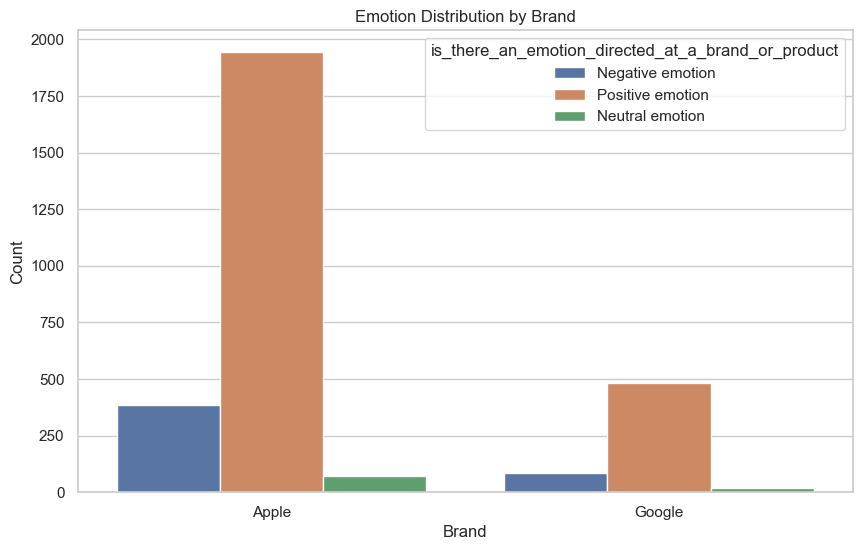

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='brand', hue='is_there_an_emotion_directed_at_a_brand_or_product', data=df)

# Add labels and title
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Emotion Distribution by Brand')

# Show the plot
plt.show()


Analysing the most common hashtags.

C:\Users\user\AppData\Local\Temp\ipykernel_16888\310914120.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_hashtags.values, y=top_10_hashtags.index, palette="viridis")


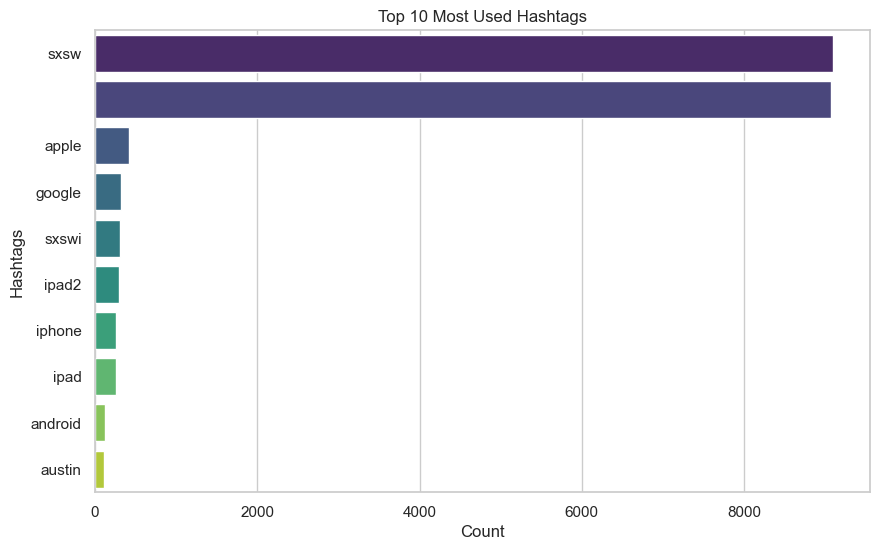

In [21]:
# Example DataFrame
hashtags_df = pd.DataFrame()

# Split the hashtags into a list
hashtags_df['hashtags_list'] = df['hashtags'].str.split(',')

# Flatten the list of hashtags
flat_hashtags_list = [item for sublist in hashtags_df['hashtags_list'] for item in sublist]

# Create a Series to count the occurrences of each hashtag
hashtags_counts = pd.Series(flat_hashtags_list).value_counts()

# Select the top 10 hashtags
top_10_hashtags = hashtags_counts.head(10)

# Plot the word count for the top 10 hashtags
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_hashtags.values, y=top_10_hashtags.index, palette="viridis")
plt.title('Top 10 Most Used Hashtags')
plt.xlabel('Count')
plt.ylabel('Hashtags')
plt.show()


In [22]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame and the column name is 'is_there_an_emotion_directed_at_a_brand_or_product'
column_name = 'is_there_an_emotion_directed_at_a_brand_or_product'

# Create a LabelEncoder object
enc = LabelEncoder()

# Fit and transform the specified column in the DataFrame
df[column_name] = enc.fit_transform(df[column_name])

df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

1    5528
2    2968
0     569
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

### Data Preprocessing
Most of the crucial steps like removing links and hashtags as well as special characters was performed in the data cleaning process.

However although the text we have remained with is "cleaned". Some preprocessing can be added to enable our model to become better.

In this section we will attempt to remove stop words and non English words.

In [26]:
# Load the stop words
stop_words = set(stopwords.words('english'))

# Assuming df is your DataFrame and 'clean_text' is the column containing the tweets
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_text,hashtags,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,G iPhone hrs tweeting RISEAustin dead need upg...,"rise_austin,sxsw,",Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,2,Know Awesome iPadiPhone app youll likely appre...,"sxsw,",Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,2,wait iPad also sale SXSW,"ipad,sxsw,",Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,hope years festival isnt crashy years iPhone a...,"sxsw,",Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,2,great stuff Fri SXSW Marissa Mayer Google Tim ...,"sxsw,",Google


In [25]:
# Load the stop words and English words set
stop_words = set(stopwords.words('english'))
english_words = set(words.words())

# Assuming df is your DataFrame and 'clean_text' is the column containing the tweets
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words and word.lower() in english_words]))

df.head()

LookupError: 
**********************************************************************
  Resource [93mwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('words')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/words[0m

  Searched in:
    - 'C:\\Users\\user/nltk_data'
    - 'c:\\Users\\user\\anaconda3\\nltk_data'
    - 'c:\\Users\\user\\anaconda3\\share\\nltk_data'
    - 'c:\\Users\\user\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\user\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


### Data Modelling.

#### Base Model

In [ ]:
# Assuming 0 is positive and 2 is negative
binary_df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'].isin([0, 2])].copy()

# Map 0 to negative and 1 to positive
binary_df['is_there_an_emotion_directed_at_a_brand_or_product'] = binary_df['is_there_an_emotion_directed_at_a_brand_or_product'].map({0: 1, 2: 0})

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(binary_df['clean_text'], binary_df['is_there_an_emotion_directed_at_a_brand_or_product'], test_size=0.2, random_state=42)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()


In [ ]:
classifier.fit(X_train_vec, y_train)


LogisticRegression()

In [ ]:
predictions = classifier.predict(X_test_vec)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)


Accuracy: 0.8559322033898306
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       595
           1       0.92      0.11      0.19       113

    accuracy                           0.86       708
   macro avg       0.89      0.55      0.56       708
weighted avg       0.87      0.86      0.80       708



The provided results pertain to a classification model's performance, with an overall accuracy of 85.31%. The classification report provides more detailed insights into the model's effectiveness by breaking down its performance across different classes. The model appears to perform well on the majority class (0), achieving a precision of 85% and recall of 100%, resulting in a high F1-score of 92%. However, the model struggles with the minority class (1), as reflected by a lower precision of 91%, low recall of 9%, and a consequently low F1-score of 16%. The weighted average F1-score across both classes is 80%, indicating a reasonable overall model performance. The macro-average F1-score, which gives equal weight to both classes, is 54%, suggesting imbalances in performance between the two classes. In summary, while the model exhibits good accuracy, its effectiveness varies significantly between the majority and minority classes, warranting attention to potential class imbalance issues or the need for targeted improvements in handling the minority class.

#### Multiclass Model

Though the baseline model is okay. Improvements can be made. As an example creating a multiclass model that can incorporate the neutral class as well. This might yield better results.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['is_there_an_emotion_directed_at_a_brand_or_product'], test_size=0.2, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
classifier = SVC(kernel='linear', C=1.0)

In [ ]:
classifier.fit(X_train_vec, y_train)

SVC(kernel='linear')

In [ ]:
predictions = classifier.predict(X_test_vec)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.6729178157749587
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.13      0.23       119
           1       0.69      0.88      0.77      1112
           2       0.61      0.39      0.47       582

    accuracy                           0.67      1813
   macro avg       0.69      0.47      0.49      1813
weighted avg       0.67      0.67      0.64      1813



In [ ]:
# Create a binary target variable
df['binary_sentiment'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(
    lambda x: 'Negative' if x in ["No emotion toward brand or product", "I can't tell"] else 'Positive'
)

# Verify the distribution of the new binary target
binary_sentiment_distribution = df['binary_sentiment'].value_counts()
print("Distribution of 'binary_sentiment' values:")
print(binary_sentiment_distribution)


NameError: name 'df' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Split the dataset into training and testing sets
X = df['clean_text']  # Features
y = df['binary_sentiment']  # Binary target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with CountVectorizer and Logistic Regression
model = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=1000))

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Positive')
recall = recall_score(y_test, y_pred, pos_label='Positive')
f1 = f1_score(y_test, y_pred, pos_label='Positive')

conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


NameError: name 'df' is not defined